# Star Finder and Imexam

This notebook will guide you through the steps necessary for detecting stars in your overscan subtracted, trimmed, bias subtracted, flat fielded science frames.

Doing aperture photometry requires that you be able to find stars in your image. Manually identifying the positions of stars in DS9 is not scalable to large numbers of stars or frames. Therefore, we will use the detection tools in PHOTUTILS. You can see example code and documentation here:

<a href="https://photutils.readthedocs.io/en/stable/detection.html">Star finder example code</a> <br>
<a href="https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder">DAOStarFinder documentation</a> <br>
<a href="https://imexam.readthedocs.io/en/0.9.1/">imexam</a> <br>
<a href="https://imexam.readthedocs.io/en/latest/api/imexam.imexamine.Imexamine.html#imexam.imexamine.Imexamine.radial_profile">imexam radial profiles</a> <br>
<a href="https://github.com/spacetelescope/imexam">imexam repo with some example notebooks</a> <br>

In [143]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from imexam.imexamine import Imexamine
from astropy.coordinates import SkyCoord

In [3]:
# grab show_image
phot_tutorial_dir = '/Users/runnojc1/Dropbox/Research/teaching/F2021/ASTR8060/work/reductions/example/notebooks'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [4]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=12)
rc('axes', grid=True)

In [5]:
# define directories
reduced_dir = '/Users/runnojc1/Dropbox/Research/teaching/F2021/ASTR8060/Imaging_reduced/' # working directory

## 1. Find bright stars in the middle of your frame

The star finder implemented in PHOTUTILS is an implementation of <a href="https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract">DAOPHOT</a>. Generally speaking, it looks for peaks in the distribution of pixel values in a frame. The challenges are to detect real stellar peaks near the level of the background and/or noise in the image, and to distinguish stellar peaks from various kinds of noise spikes and other astronomical sources (e.g., galaxies).


<b>Look at the documentation and DAOPHOT paper to answer the following:</b>
 - How do you control how faint the stars you find are? <br>
 - How do you avoid saturated stars?<br>
 - What is sharpness?<br>
 - What is roundness?<br>

<b>Read in the data and plot the image</b>

Plot the central part of the frame for columns 750-1250 and rows 1000-1500 for a085otzf.fits.

In [151]:
# read in the data


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [154]:
# set the column and row range of interest
row_lo = 0
row_hi = 0
col_lo = 0
col_hi = 0

/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """
/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


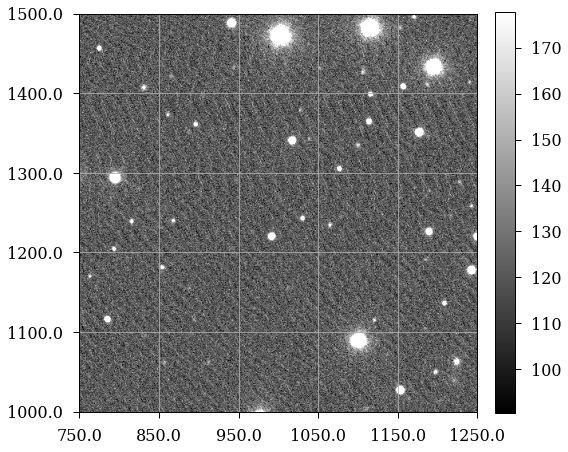

In [153]:
# plot only the center of the frame from col_lo to col_hi and row_lo to row_hi
# the tricky part here is to make sure the axis labels have the right values
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# add code to plot here
ax.set_xticklabels(ax.get_xticks()+col_lo)
ax.set_yticklabels(ax.get_yticks()+row_lo)
plt.tight_layout()
plt.show()

<b> Find the bright stars </b>
Look at the Star Finder example code to see the syntax for this. You will need a guess for fwhm (we'll measure this next). Approximately how many pixels would be reasonable starting guess? (The size of a faint start might be a good starting place.)

In [ ]:
# write code based on the example notebook
# the line below is just to show you what the "sources" variable should be for later cells
sources = daofind(data) 

<b> Plot the image again and mark the detected stars </b>

Making apertures at the position of the stars you detect would be a good method for showing where they are.

/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


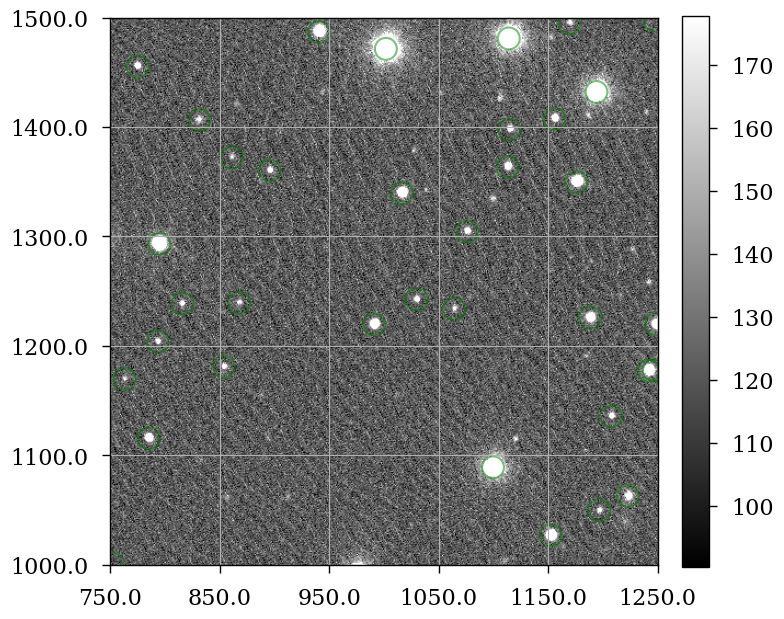

In [118]:
positions = [(x,y) for x,y in zip(sources['xcentroid'],sources['ycentroid'])] # this syntax is handy for apertures

## 2. Measure the PSF FWHM

The point spread function (PSF) full width at half maximum (FWHM) is a measure of the width in pixels where light from a point source is distributed on the CCD. Many of the detection methods above take the PSF FWHM as an input to help distinguish from noise spikes. Also, you may want to explore the PFS as a function of time or position on the CCD. Thus, it is worthwhile to know how to measure it.

A simple estimate for the PSF FWHM would find the 1D Gaussian distribution of light from a single star in a column or row and determine its width. More complex algorithms include centroiding, 2D model fitting, and background subtraction. The imexam package includes these and many more tools. 

(Imexam also has many interactive tools and can run with DS9, but it is finicky to get the display set up. See the accompanying notebook if you are feeling extremely bold.)


We will use imexam to create a radial profile plot. This shows the azimuthally averaged value of the counts in a frame as a function of radius from the star centroid. The FWHM is taken from the width of this (Gaussian) profile.

A warning about the radial profiles in imexam: they can fail with various errors if the position is near the edge of the frame.

<b>Calculate the FWHM for the sources you found in the previous step.</b>

In [120]:
#initalize the object to get access to the plotting functions
plots=Imexamine() 

xc=1325.9586	yc=1054.5066
Background per pixel: 122.229196401199
Max. pix. flux =   217.279
amp =   221.774
fwhm =     3.769


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


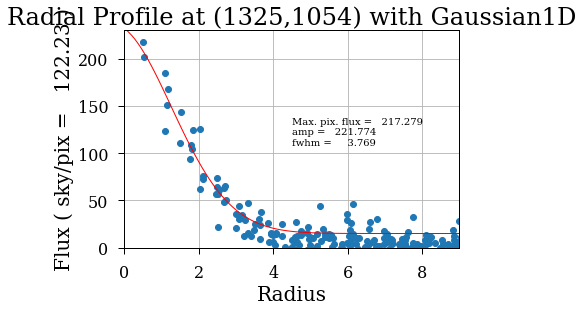

xc=1002.7671	yc=752.9526
Background per pixel: 121.40881819564103
Max. pix. flux =    39.965
amp =    48.322
fwhm =     0.000


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


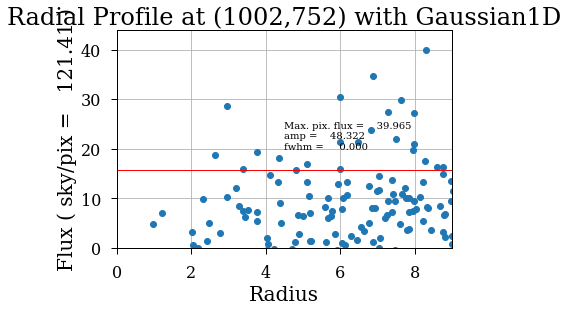

xc=1402.3337	yc=776.9687
Background per pixel: 124.08353899816115
Max. pix. flux =  1856.060
amp =  1946.235
fwhm =     4.055


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


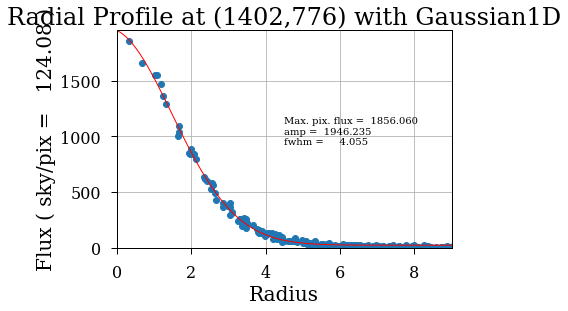

xc=1446.4450	yc=799.7423
Background per pixel: 122.43207183578428
Max. pix. flux =    93.963
amp =    80.243
fwhm =     3.188


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


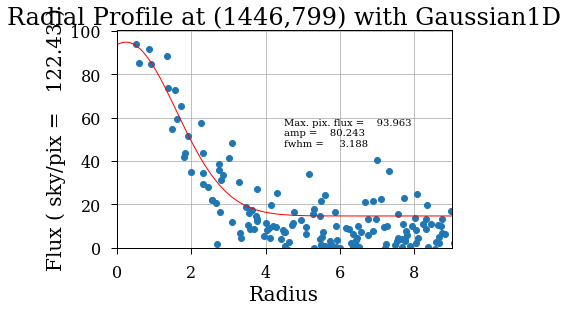

xc=1472.9026	yc=812.6089
Background per pixel: 123.8178305062511
Max. pix. flux =   142.358
amp =   155.273
fwhm =     5.768


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


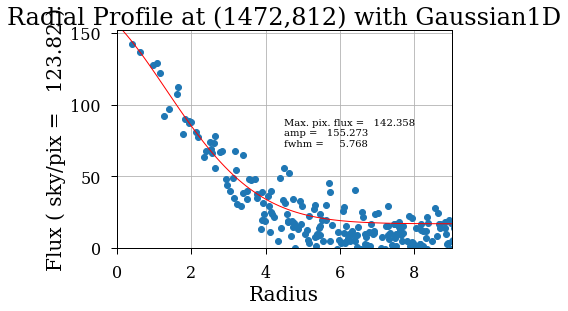

xc=1349.5297	yc=839.0430
Background per pixel: 147.0221758603449


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux = 26920.847
amp = 31237.584
fwhm =     4.330


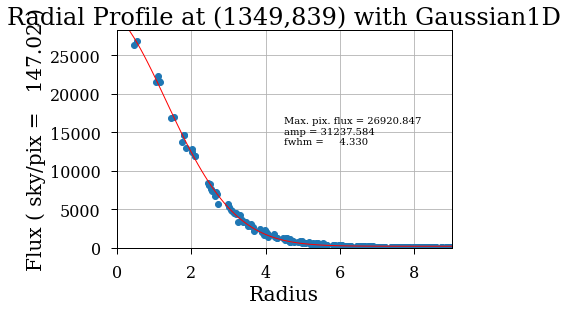

xc=1035.1886	yc=865.7308
Background per pixel: 122.86532896569501
Max. pix. flux =   598.497
amp =   641.428
fwhm =     4.100


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


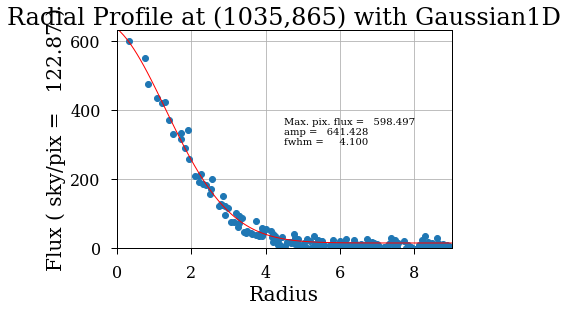

xc=1457.4400	yc=885.8249
Background per pixel: 121.49518036996463
Max. pix. flux =   165.940
amp =   148.214
fwhm =     3.942


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


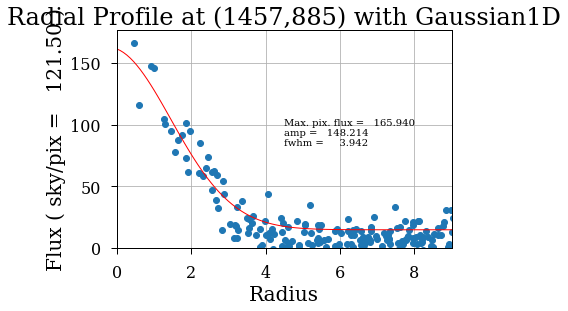

xc=1013.2042	yc=919.7243
Background per pixel: 121.61987494335962


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =    83.160
amp =    57.538
fwhm =     2.832


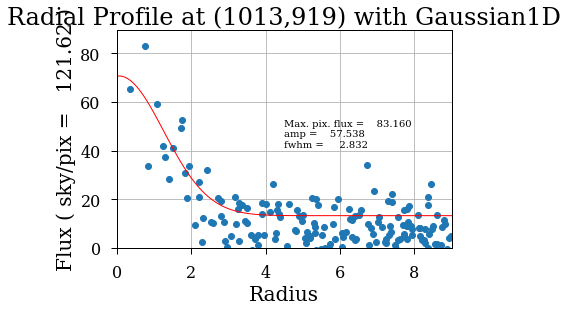

xc=1491.4060	yc=927.4061
Background per pixel: 123.82881618301757
Max. pix. flux =  1719.030
amp =  1877.278
fwhm =     3.996


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


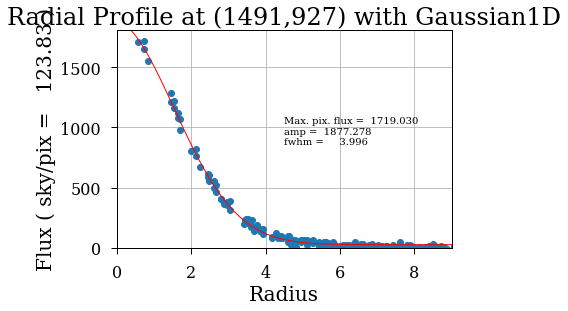

xc=1491.4061	yc=927.4061
Background per pixel: 123.82889581564571
Max. pix. flux =  1719.030
amp =  1877.285
fwhm =     3.996


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


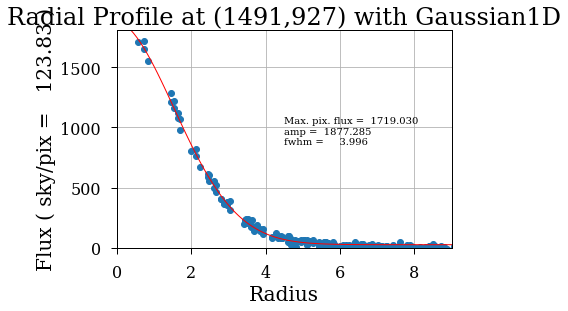

xc=1103.8717	yc=930.8583
Background per pixel: 122.14609428256453
Max. pix. flux =   147.671
amp =   116.007
fwhm =     2.678


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


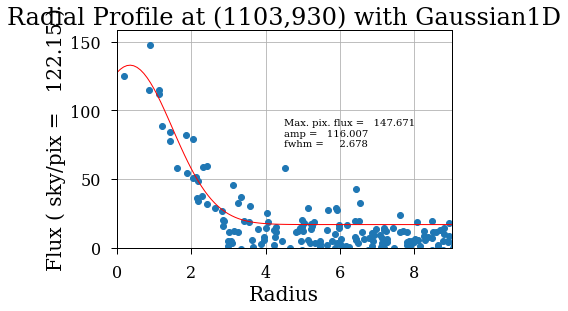

xc=1043.4543	yc=953.9981
Background per pixel: 120.8510290998062


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =   143.907
amp =   137.363
fwhm =     3.963


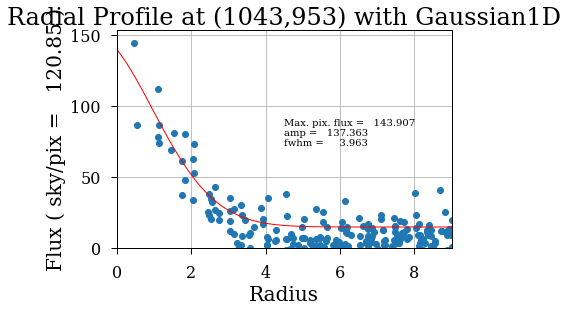

xc=1240.9253	yc=969.6429
Background per pixel: 122.204942408379


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =   943.719
amp =  1010.184
fwhm =     3.998


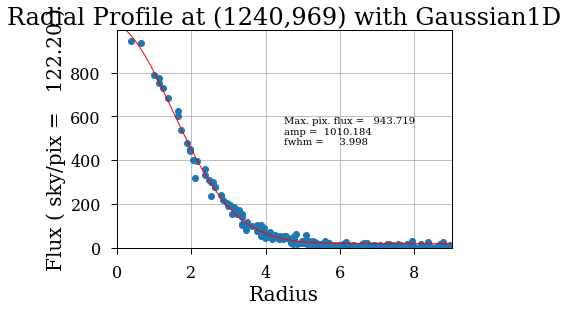

xc=1498.9102	yc=969.5444
Background per pixel: 122.90712265725315


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =  1381.803
amp =  1457.045
fwhm =     3.934


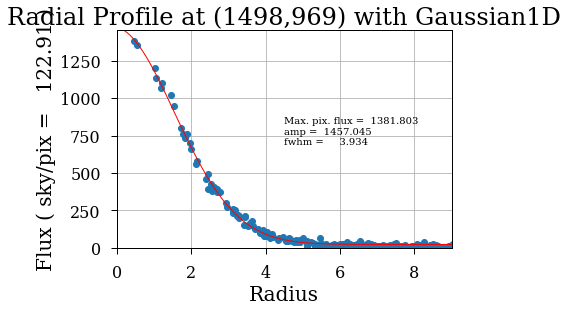

xc=1438.1057	yc=975.7994
Background per pixel: 121.59829079536601
Max. pix. flux =   904.632
amp =   887.662
fwhm =     3.676


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


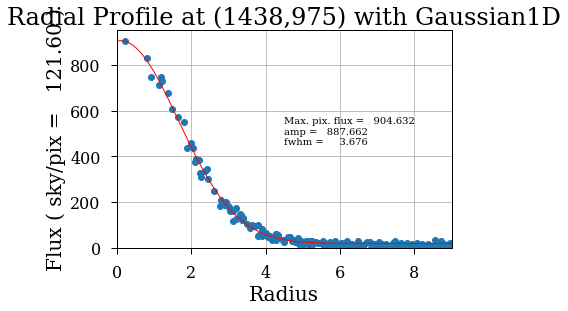

xc=1314.1237	yc=983.8432
Background per pixel: 121.47315023920129
Max. pix. flux =    78.824
amp =    54.035
fwhm =     2.470


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


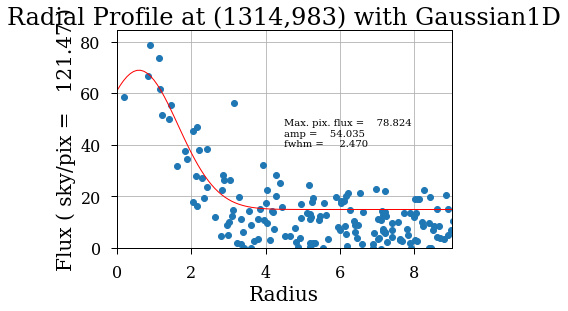

xc=1065.6208	yc=988.6306
Background per pixel: 121.48233778825426
Max. pix. flux =   105.819
amp =    81.056
fwhm =     2.548


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


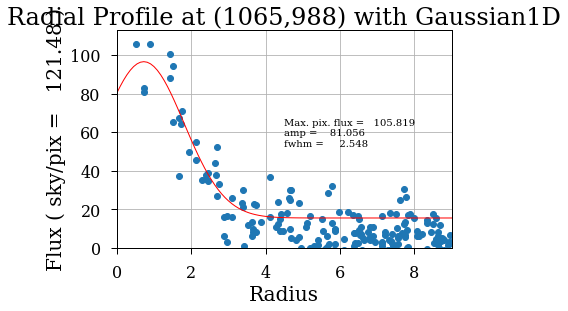

xc=1117.7389	yc=989.4335
Background per pixel: 120.96027410178216


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =    81.019
amp =    62.018
fwhm =     2.527


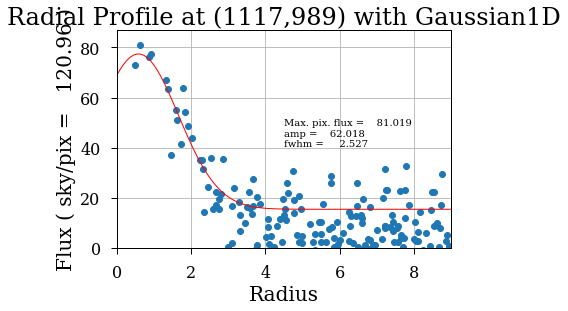

xc=1279.6695	yc=992.5225
Background per pixel: 121.64639467701294
Max. pix. flux =   157.708
amp =   122.559
fwhm =     2.840


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


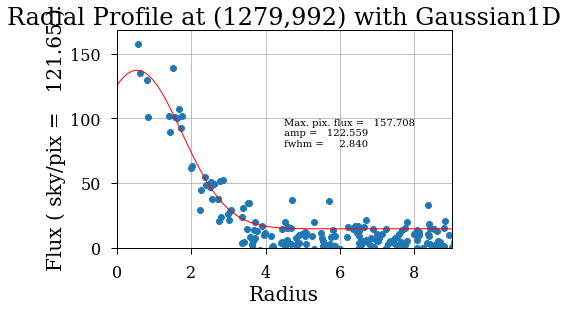

xc=1044.8039	yc=1043.2179
Background per pixel: 128.78513746976782
Max. pix. flux =  7114.349
amp =  7670.662
fwhm =     4.117


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


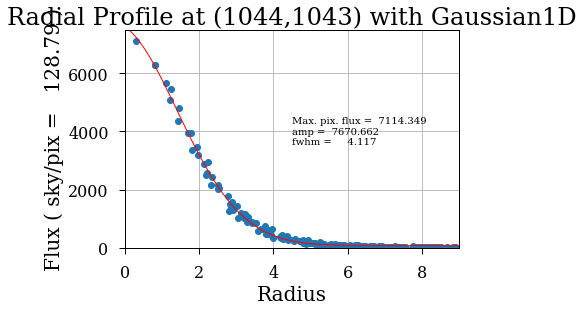

xc=1325.9584	yc=1054.5068
Background per pixel: 122.22921770039936
Max. pix. flux =   217.279
amp =   221.775
fwhm =     3.769


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


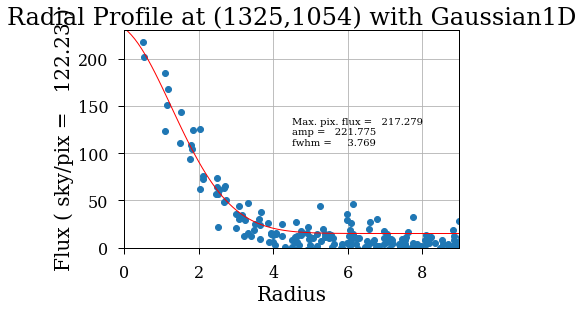

xc=1266.4365	yc=1089.6139
Background per pixel: 123.41852975986818


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =  1518.478
amp =  1783.241
fwhm =     4.238


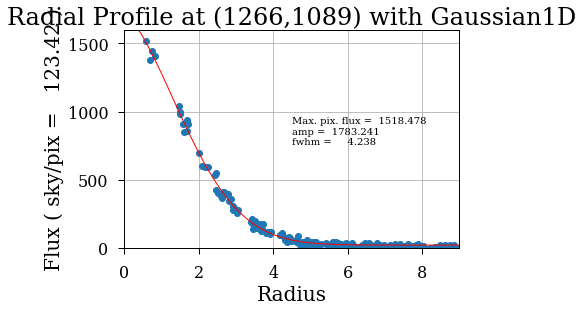

xc=1425.8149	yc=1099.8366
Background per pixel: 123.60928121409296
Max. pix. flux =  2086.909
amp =  2152.545
fwhm =     3.967


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


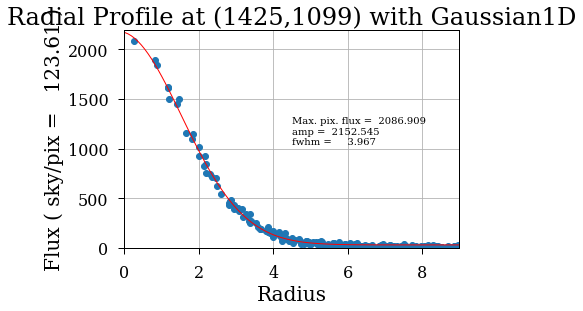

xc=1145.6391	yc=1110.2145
Background per pixel: 122.72212666286389
Max. pix. flux =   154.782
amp =   143.477
fwhm =     3.383


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


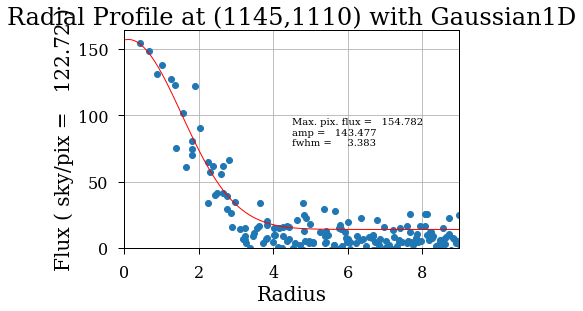

xc=1362.9318	yc=1113.6254
Background per pixel: 122.37873958838748
Max. pix. flux =   377.078
amp =   363.654
fwhm =     3.736


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


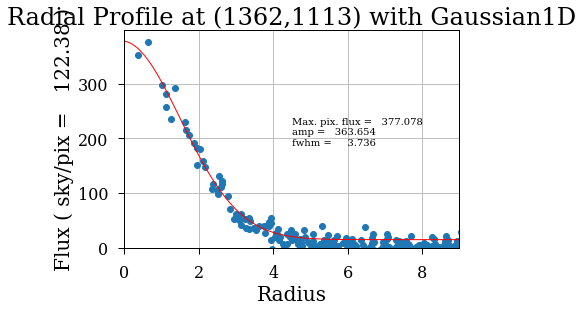

xc=1110.9853	yc=1122.2783
Background per pixel: 121.59344572746416


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =    74.902
amp =   660.101
fwhm =     8.862


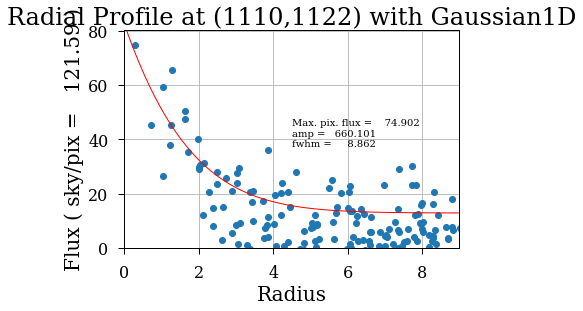

xc=1364.7469	yc=1147.7296
Background per pixel: 121.67474556092665


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =   176.877
amp =   188.040
fwhm =     4.099


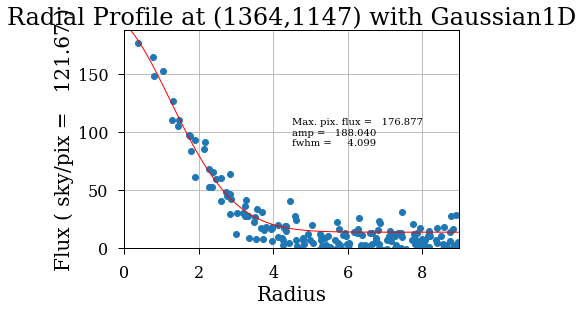

xc=1080.9129	yc=1156.2359
Background per pixel: 121.57449372849058


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =    87.752
amp =    89.825
fwhm =     5.565


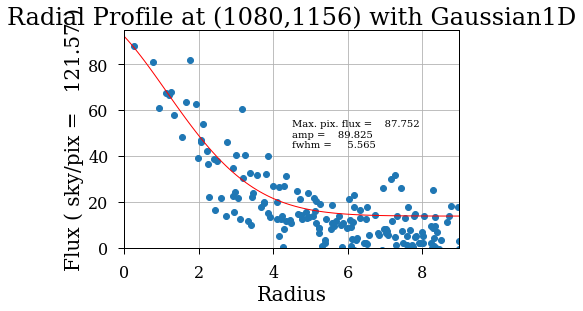

xc=1405.7903	yc=1157.5348
Background per pixel: 123.27427918614717
Max. pix. flux =   326.837
amp =   341.437
fwhm =     3.790


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


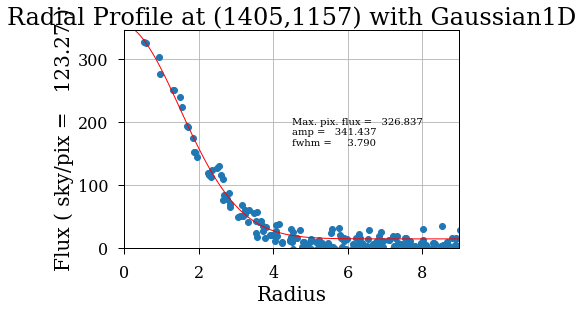

xc=1444.0143	yc=1182.0363
Background per pixel: 150.63087164918196
Max. pix. flux = 30866.649
amp = 31541.551
fwhm =     4.077


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


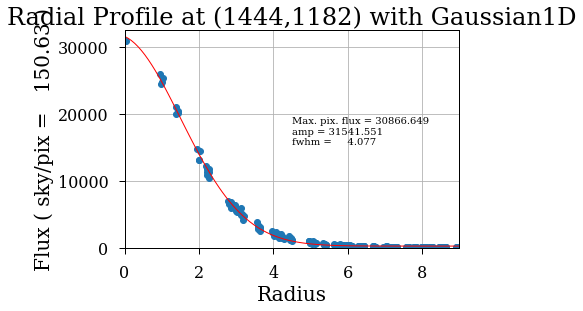

xc=1024.9454	yc=1205.3718
Background per pixel: 121.72200750132806
Max. pix. flux =   216.312
amp =   252.364
fwhm =     4.278


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


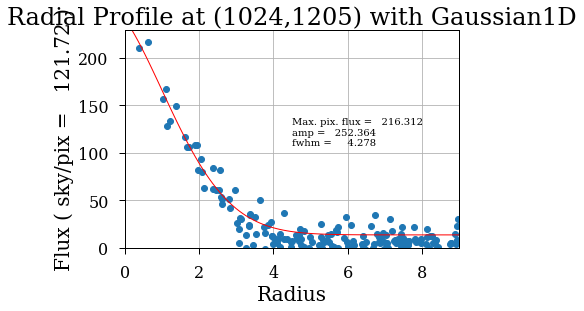

xc=1251.6690	yc=1221.4308
Background per pixel: 173.86225044647728


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux = 56069.673
amp = 66135.773
fwhm =     4.229


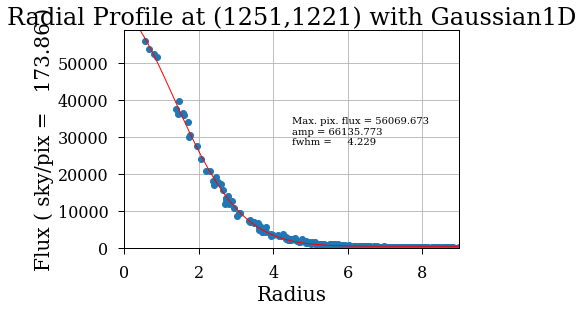

xc=1363.9822	yc=1230.9675
Background per pixel: 162.09739791903806
Max. pix. flux = 47169.647
amp = 48273.801
fwhm =     4.031


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


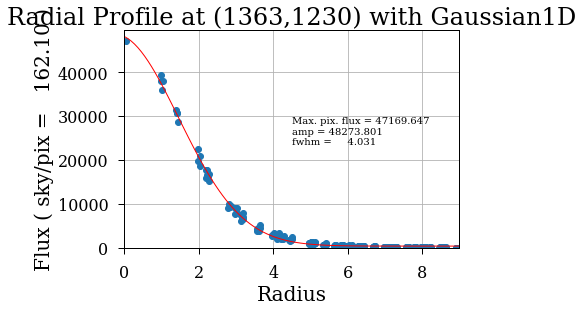

xc=1190.4407	yc=1236.8837
Background per pixel: 124.85713202175619
Max. pix. flux =  2726.502
amp =  3022.466
fwhm =     4.027


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


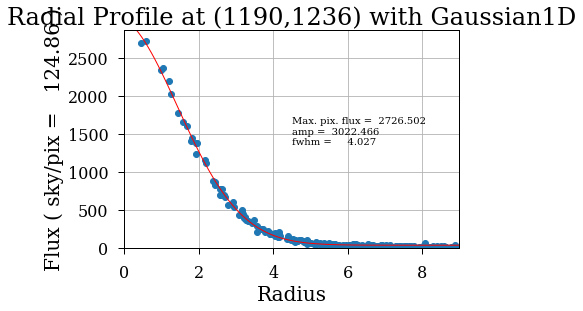

xc=1419.4226	yc=1244.7757
Background per pixel: 123.0574708094632
Max. pix. flux =   105.607
amp =  1449.161
fwhm =     9.473


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


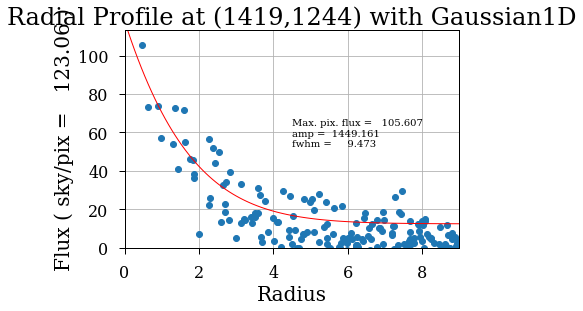

xc=1488.5110	yc=1247.0681
Background per pixel: 120.46892317494404


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/imexam/math_helper.py:177: RuntimeWarning: invalid value encountered in log
  z = np.nan_to_num(np.log(flux))


Max. pix. flux =    38.942
amp =    10.582
fwhm =     0.071


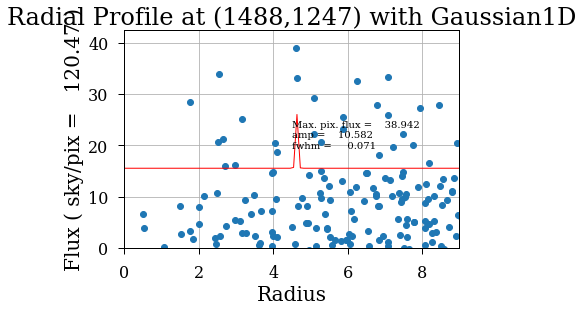

In [149]:
# here is one radial profile at 1325,1054
plots.radial_profile(1325,1054,data,genplot=True)

# loop over the x and y centroids from the star finder
# and generate a radial profile for each one
# how much does the FWHM vary between these?
for x,y in zip(sources['xcentroid'],sources['ycentroid']):
    print(x,y) # dummy loop, add code here to do radial profiles

## 3. Write a function to do aperture photometry

Write a function that takes a filename and:

1. Reads in the data.
2. Finds all the sources in the image.
3. Puts a circular aperture and background annulus on each of the stars.
4. Calculates background-subtracted instrumental magnitudes.
5. Plots the image and apertures for visual inspection.
6. Returns a table of photometry, including the instrumental magnitudes.

Run your function on a085otzf.fits.

In [157]:
def get_phot(filename):
    # do photometry
    phot = 0
    return phot

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/Users/runnojc1/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


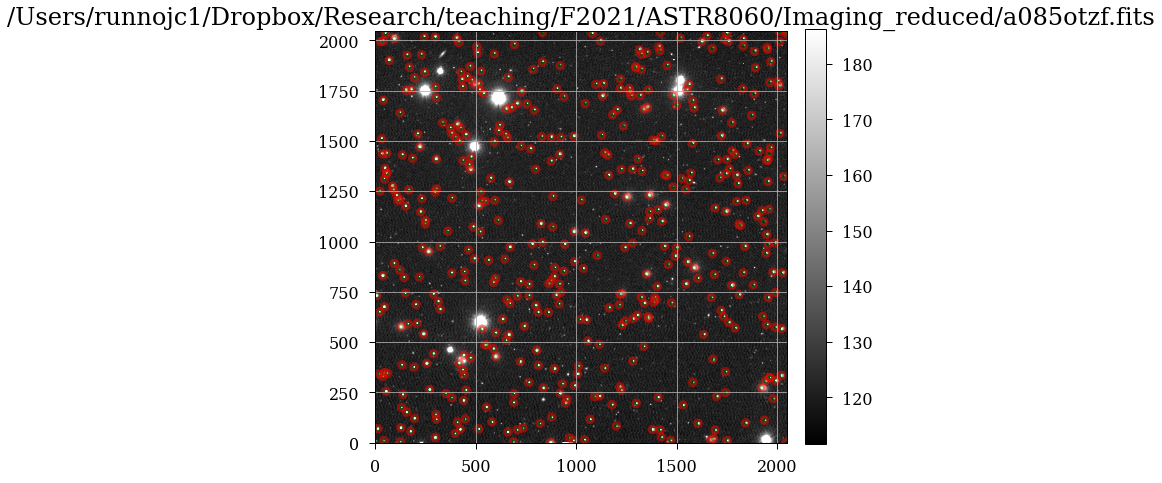

id,xcenter,ycenter,aperture_sum,inst_mag
,pix,pix,,
int64,float64,float64,float64,float64
1,873.54204,0.85529202,489178.74,-14.17373
2,2045.548,1.4169481,14635.458,-8.9160031
3,688.00279,3.9507222,32858.069,-10.044549
4,127.82611,5.6236807,35715.755,-10.214331
5,44.554311,11.158886,40864.091,-10.294757
6,984.73065,12.322523,45557.729,-9.4894149
7,1468.4608,12.246134,43594.726,-10.303692
8,1749.025,11.883831,53721.535,-10.978235


In [196]:
phot = get_phot(reduced_dir+'a085otzf.fits')
phot